# Midterm Exam

- **Subject:** Computational Physics I
- **Date:** Tuesday 27 June 2023
- **Credits:** 30 points
- **Number of problems:** 6
- **Type of evaluation:** Midterm Exam

## Instructions:

- When you finish, please send your .ipynb file via email to wbanda@yachaytech.edu.ec


- The exam is open-book and has two parts:

**Part 1** should be submitted **individually** by the end of the class today.

        
**Part 2** can be submitted **individually or in pairs** by Friday 7th July (by the end of the day).


- You can call your notebook with your surname/s, e.g. name.ipynb, and also include your name/s in the notebook.


- Within a **single python notebook**, add the following:

## Name: Gabriel Balarezo 

In [38]:
# Fist, let's import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import scipy.optimize as opt
from astropy.io import fits
import os
import scipy.constants as const 
from skimage.feature import peak_local_max
import glob 
from IPython import display
from PIL import Image 
import scienceplots

In [39]:
# Set plot style
plt.style.use(['science', 'notebook', 'no-latex'])

## Part II (18 points): due by Friday 7 July (by the end of the day)

### 4. (6 points) Period of the tide using sea level data

The goal of this exercise is to calculate the period of the sea level change with the tide. For this, we are going to use sea level measurements from the data base of the University of Hawaii: 

http://uhslc.soest.hawaii.edu/data/?fd

These data sets were collected from more than $500$ tide gauge stations across the globe.

**Reference:**
Caldwell, P. C., M. A. Merrifield, P. R. Thompson (2015), Sea level measured by tide gauges from global oceans — the Joint Archive for Sea Level holdings (NCEI Accession 0019568), Version 5.5, NOAA National Centers for Environmental Information, Dataset, doi:10.7289/V5V40S7W.

(a) Go to the website of the sea level data base and search for measurements from Ecuador. Download the "Research Quality" "hourly" data for Santa Cruz. These data sets are **csv** files with 5 columns each (year, month, day, hour, sea level). The units of the sea level data are $\rm mm$.

In [40]:
#cat "./h030a.csv"

(b) Using pandas, read in the data from the data files and check the data by ploting the sea level measurement against the hours.

In [41]:
# Define a function to read the file
def file_read(filename):
    """
    Function to read a file using pandas 
    and put the data into a numpy array.
    
    Arguments:
            - filename (str) : the name of the file to read

    Returns:
            - df (pandas dataframe) : the data in a pandas dataframe
            - hour (np.array)       : time data array
            - sea_level (np.array)  : sea level data array
    """
    df = pd.read_csv(filename, sep = ",")
    hour = np.array(df.iloc[:, 3])
    sea_level = np.array(df.iloc[:, 4])
    
    return df, hour, sea_level

In [42]:
# Call the function 
df, hour, sea_level = file_read("./h030.csv")

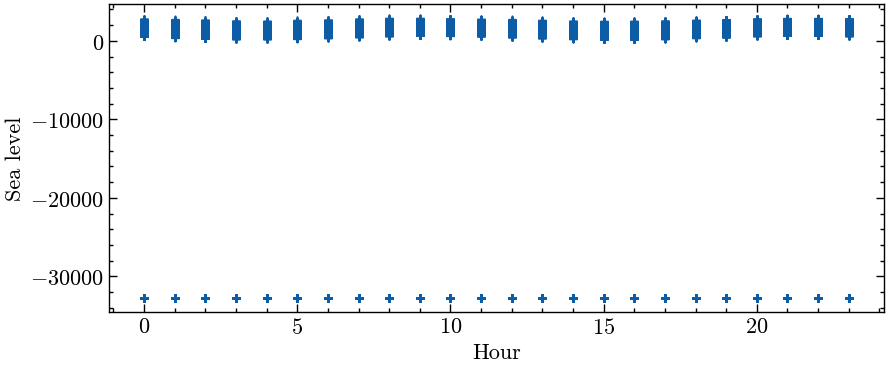

In [43]:
# Plot sea level vs. hour
fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(hour, sea_level, linestyle = ' ', marker = "+")
ax.set_xlabel("Hour")
ax.set_ylabel("Sea level")

plt.show()
plt.close()

(c) Remove extreme outliers from the data. Outliers show up as negative values that occur when instruments fail.

In [44]:
# To delete the outliers (negative values), let's use indexing
index = sea_level >= 0

filter_sea_level = sea_level[index]
filter_hour = hour[index]

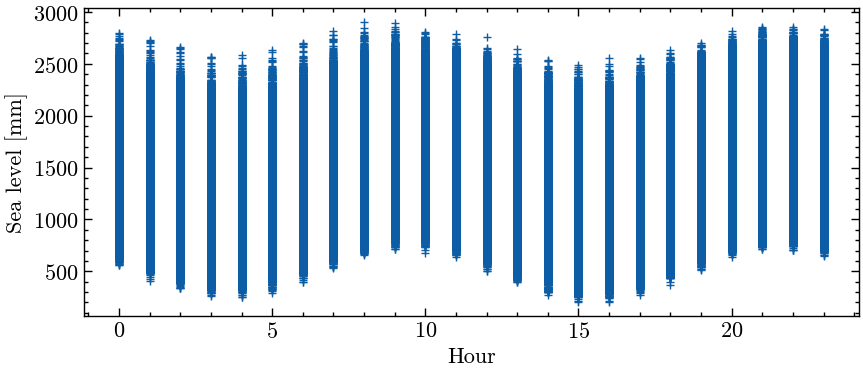

In [45]:
# Plot sea level vs. hour
fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(filter_hour, filter_sea_level, linestyle = ' ', marker = "+")
ax.set_xlabel("Hour")
ax.set_ylabel("Sea level [mm]")

plt.show()
plt.close()

(d) Calculate the average sea level at each hour for Santa Cruz and make a plot (average sea level against hours). What trend do you notice in the data?

In [46]:
# Let's create a pandas dataframe with the filtered hour and sea level values 
df2 = pd.DataFrame({'filter_hour': filter_hour, 'filter_sea_level': filter_sea_level})

# Now let's group the data by hour and compute the mean sea level and standard deviation 
hourly_stats = df2.groupby('filter_hour')['filter_sea_level'].agg(['mean', 'std'])

In [47]:
# Now, let's get plot the mean sea level
# Put into numpy arrays
hour_array = hourly_stats.index.values
mean_sea_level = hourly_stats["mean"].values
stdv = hourly_stats["std"].values

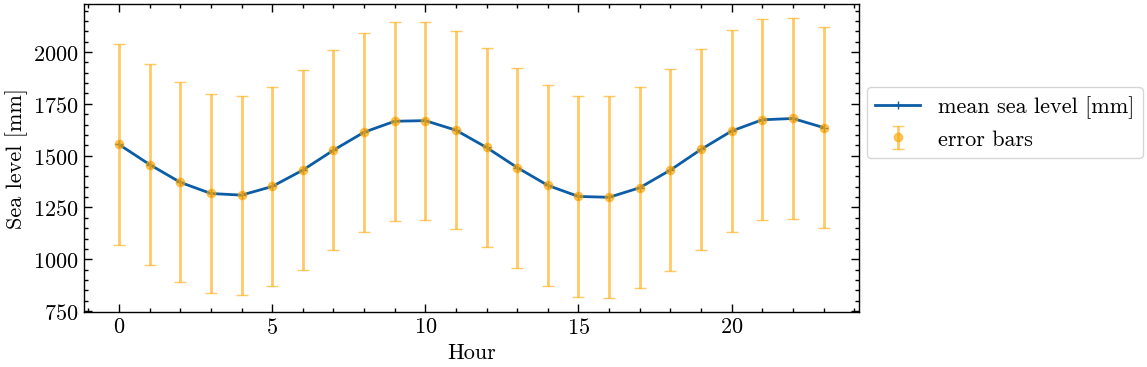

In [48]:
# Plotting 
fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(hour_array, mean_sea_level, linestyle = '-', marker = "+", label = "mean sea level [mm]")
ax.errorbar(hour_array, mean_sea_level, yerr = stdv, linestyle = ' ', color = 'orange',
           fmt = 'o', alpha = 0.6, capsize = 4, label = "error bars")

ax.set_xlabel("Hour")
ax.set_ylabel("Sea level [mm]")

ax.legend(loc = (1.01, 0.5), frameon = True)

plt.show()
plt.close()

After comptuting the mean sea level, we can se that the trend follows a sinusoidal trend, which makes sense since we are studying sea level, and this is oscillatory. 


(e) Fit an appropriate function to the data to model the hourly change of the sea level also known as the tide (if you use curvefit(), I suggest providing ansatz values).

In [49]:
# Now, let's define a model to fit this data 
def TideFunction(x_values, A, B, C, D):
    """
    Function to model a tide using a sinusoidal function.

    Arguments:
            - x_values (np.array) : the time values
            - A (float) : amplitude
            - B (float) : frequency
            - C (float) : horizontal shift
            - D (float) : vertical shift
    
    Returns:
            - y_values (np.array) : the model values
    """
    
    y_values = A * np.cos( B * (x_values -  C)) + D
    
    # A -> amplitude 
    # B -> frequency
    # C -> horizontal shift
    # D -> vertical shift
    
    return y_values

In [50]:
# Define anzat values for the parameters
initial_guess = [200, 0.3, 7, 1200] 

# Let's perform the regression 

coef, cova = opt.curve_fit(TideFunction, hour_array,\
                           mean_sea_level,p0 = initial_guess, sigma = stdv)

print("Best-fit parameters", coef)

Best-fit parameters [1.88941466e+02 5.25737085e-01 9.60584106e+00 1.48880951e+03]


In [51]:
# Create a new x_axis 
new_x = np.linspace(0, 23, 1000)

# evaluate the fitted model 
fitted_y = TideFunction(new_x, *coef)

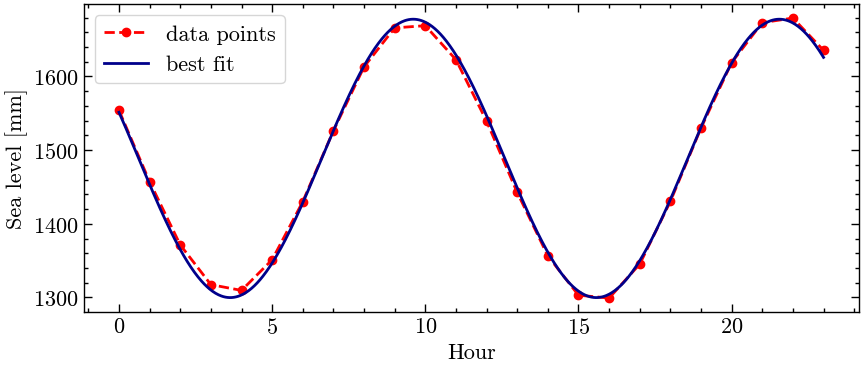

In [52]:
# Plot the fitted model and the data 
fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(hour_array, mean_sea_level, linestyle = '--', marker = "o", color = "red", label = "data points")
ax.plot(new_x, fitted_y, linestyle = '-', color = "darkblue", label = "best fit")

ax.set_xlabel("Hour")
ax.set_ylabel("Sea level [mm]")

ax.legend(loc = "best", frameon = True)

plt.show()

(f) Based on the fitted function, what period does the tide have? 

In [53]:
# Let's compute the period of the tide
# Since our parameter B is the frequency of the wave 
period = 2 * np.pi / abs(coef[1])

print(f"The period T of the tide [in  hours] is: {period} hours")

The period T of the tide [in  hours] is: 11.951192881022035 hours


In [54]:
# Let's plot the period 
p1 = 0
p2 = 11.951192881022035
p3 = p2 * 2

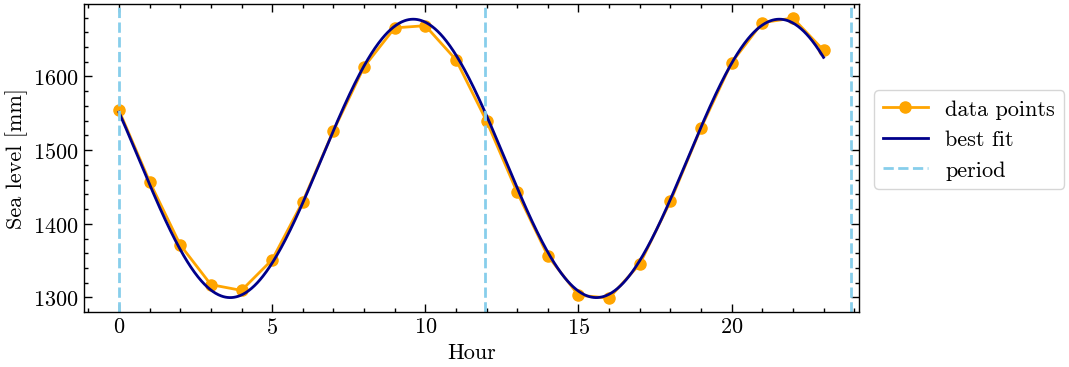

In [55]:
# Plot the fitted model and the data 
# Plot sea level vs. hour

fig, ax = plt.subplots(figsize = (10, 4))

ax.plot(hour_array, mean_sea_level, linestyle = '-', marker = "o", markersize = 8, color = "orange", label = "data points")
ax.plot(new_x, fitted_y, linestyle = 'solid', color = "darkblue", label = "best fit")


ax.axvline(x = p1, color='skyblue', linestyle = '--', label = "period")
ax.axvline(x = p2, color='skyblue', linestyle='--')
ax.axvline(x = p3, color='skyblue', linestyle='--')


ax.set_xlabel("Hour")
ax.set_ylabel("Sea level [mm]")

ax.legend(loc = (1.02, 0.4), frameon = True)

plt.show()

### 5. (6 points) Distance between colliding galaxies

The purpose of this exercise in to isolate features (galaxies) in an image by analysing the pixel information.

The sample data correspond to NGC 5765, which is a system of two merging spiral galaxies (see https://en.wikipedia.org/wiki/NGC_5765). The galaxies are in the early stages of the merger, where the interaction between them is clear, through extended arms caused by the tidal interaction, but the galaxies are still clearly separated. 

The provided data file:

https://github.com/wbandabarragan/computational-physics-1/tree/main/exams/data_sets/NGC_5765_legacy_survey.fits

contains optical images of the two galaxies from the DESI Legacy Imaging Survey (https://www.legacysurvey.org/). The FITS file contains 3 images which were taken with the g, r, z filters, which show optical light at slightly different wavelengths.

Carry out the following analysis:

(a) Read in the data from the FITS file and select the first channel of the image.

In [57]:
# Open the FITS file
with fits.open("./NGC_5765_legacy_survey.fits") as fits_data:
    # Get the data
    data = fits_data[0].data

# Access the desired data directly
galaxies = data[2]

print(galaxies.shape)

(256, 256)


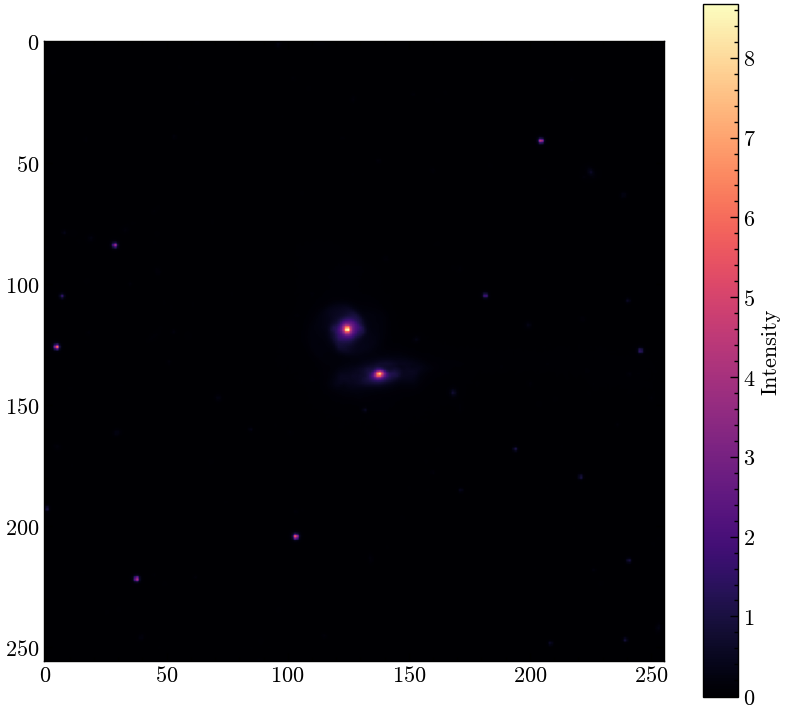

In [58]:
# Plotting 
fig, ax = plt.subplots(figsize = (10, 9))
im = ax.imshow(galaxies, cmap = "magma")
fig.colorbar(im, ax = ax, label = 'Intensity')

plt.show()
plt.close()

/tmp/ipykernel_17409/659898722.py:3: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(galaxies), cmap = "magma_r")


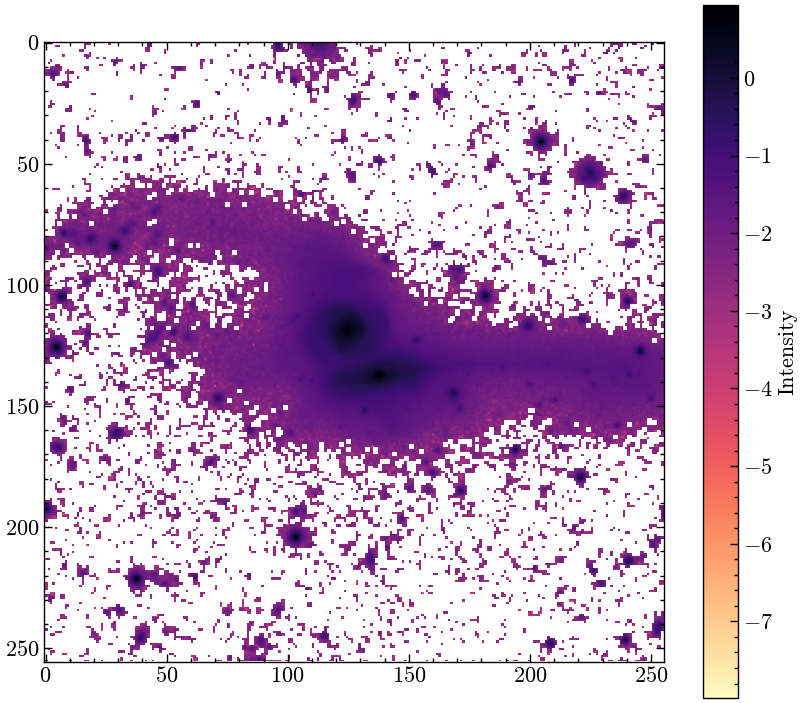

In [60]:
# Plotting log scale 
fig, ax = plt.subplots(figsize = (10, 9))
im = ax.imshow(np.log10(galaxies), cmap = "magma_r")
fig.colorbar(im, ax = ax, label = 'Intensity')

plt.show()
plt.close()

(b) Mask the image, leaving only the region containing only the merging galaxies.

In [61]:
# Let's get the region in the middle containing the two merging galaxies
galaxies_subset = np.log10(galaxies)[90: 170, 100: 170]

/tmp/ipykernel_17409/3127591803.py:2: RuntimeWarning: invalid value encountered in log10
  galaxies_subset = np.log10(galaxies)[90: 170, 100: 170]


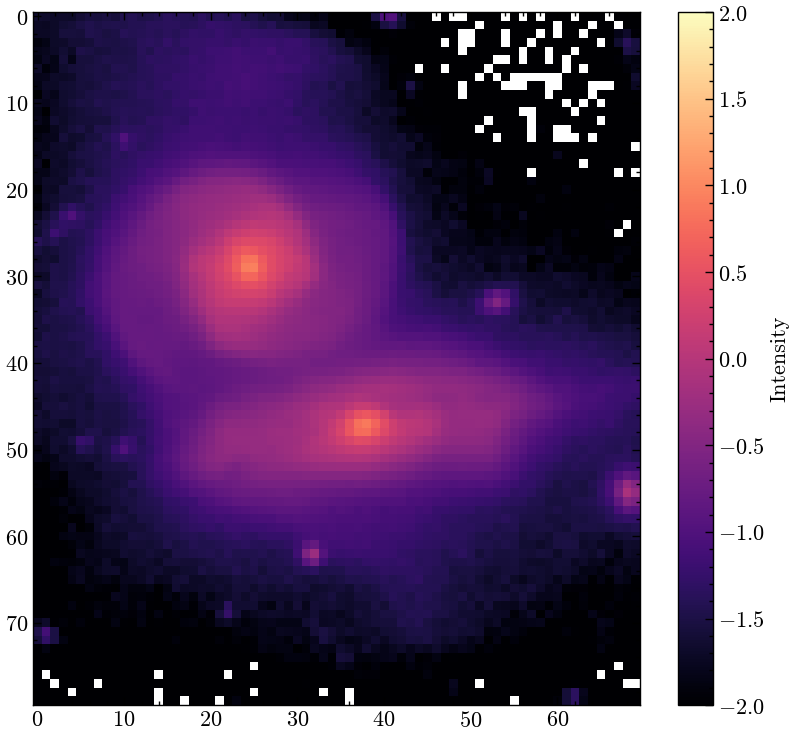

In [62]:
# Plotting 
fig, ax = plt.subplots(figsize = (10, 9))
im = ax.imshow(galaxies_subset, cmap = "magma", vmin = -2, vmax = 2)
fig.colorbar(im, ax = ax, label = 'Intensity')

plt.show()
plt.close()

In [63]:
# Now, let's create a histogram of the intensities
# Flatten the array 
galaxy_data1D = galaxies_subset.reshape(galaxies_subset.size, 1)

print(galaxy_data1D.size)

5600


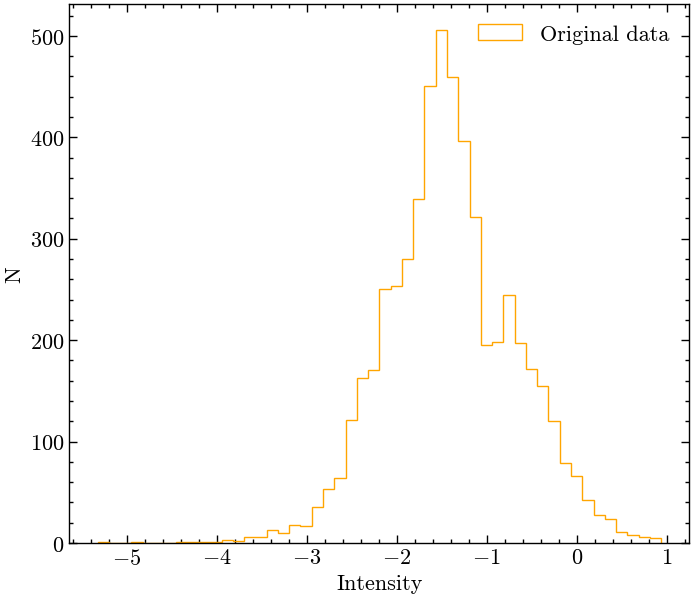

In [65]:
# Plotting the histogram
fig, ax = plt.subplots(figsize=(8, 7))

ax.hist(galaxy_data1D, bins = 50, histtype = 'step', color = 'orange', label = "Original data")

ax.set_xlabel("Intensity")
ax.set_ylabel("N")

ax.legend(loc='best')
plt.show()

In [66]:
# Let's clean the data 
# Let's  use conditionals
galaxy_data1D_clean = np.where(galaxy_data1D < -1, np.nan, galaxy_data1D)

# Reshape into a 2D cleaned image
galaxy_data2D_clean = galaxy_data1D_clean.reshape(galaxies_subset.shape)


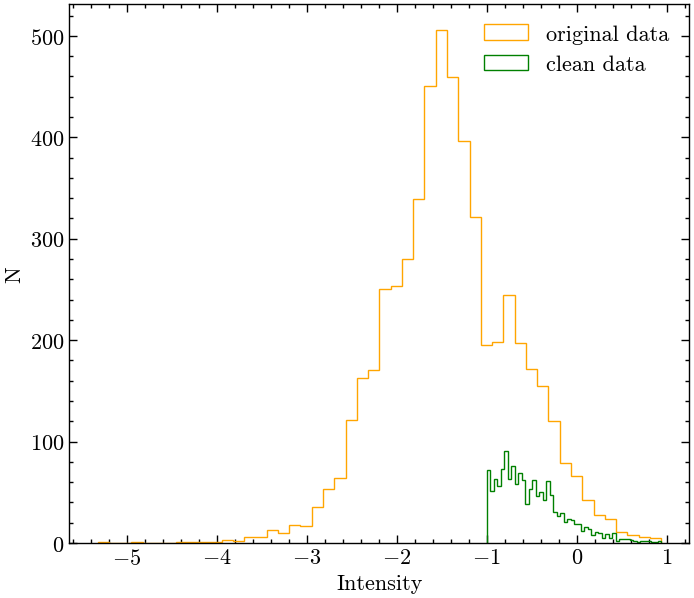

In [67]:
# Plotting the histogram
fig, ax = plt.subplots(figsize=(8, 7))

ax.hist(galaxy_data1D, bins = 50, histtype = 'step', label = 'original data', color = 'orange')
ax.hist(galaxy_data1D_clean, bins = 50, histtype = 'step', label = 'clean data', color = 'green')

ax.set_xlabel("Intensity")
ax.set_ylabel("N")

plt.legend(loc='upper right')
plt.show()

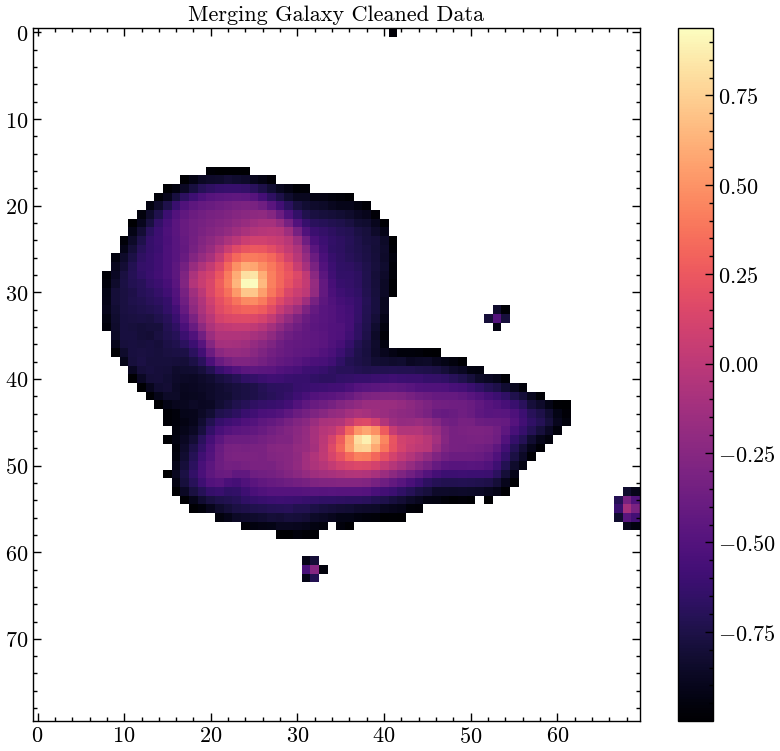

In [69]:
# Figure environment
fig, ax = plt.subplots(figsize=(10, 9))

z = ax.imshow(galaxy_data2D_clean, cmap = "magma")
plt.colorbar(z)
ax.set_title("Merging Galaxy Cleaned Data")

plt.show()

(c) Identify the centre of each galaxy. These are the two brightest regions in the image.

In [70]:
# Let's use peak_local_maxima to find the coordinates of the center of 
# the both galaxies. But, since this functions cannot handle nan's, we need to convert them into numbers.

#print(galaxy_data2D_clean)

# Convert NAN's to numbers
np.nan_to_num(galaxy_data2D_clean, copy = False, nan = 0.)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [72]:
# Lets's find the local maxima coordinates
coord_max = peak_local_max(galaxy_data2D_clean, \
                          min_distance = 1, num_peaks = 2)

print(coord_max)


[[29 25]
 [47 38]]


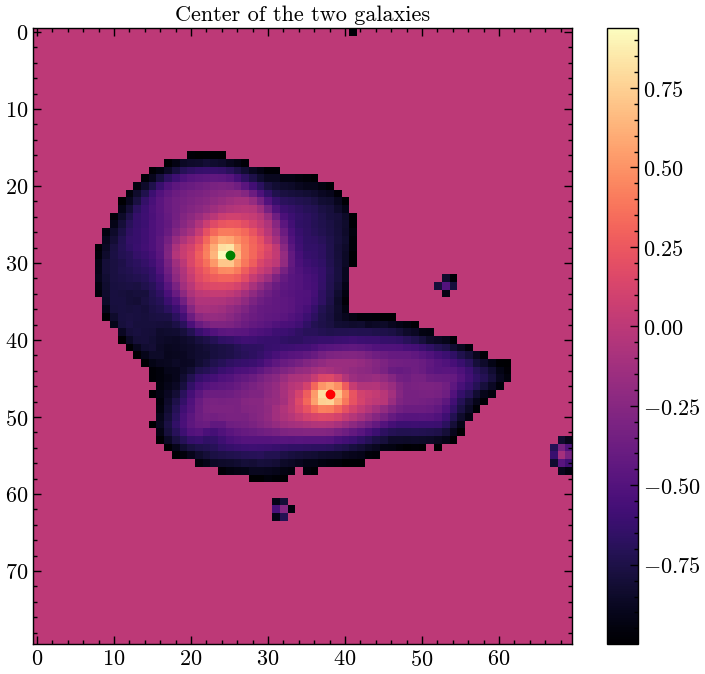

In [75]:
# Figure environment
fig, ax = plt.subplots(figsize=(9, 8))

z = ax.imshow(galaxy_data2D_clean, cmap = "magma")
ax.scatter(coord_max[0][1], coord_max[0][0], color = "green", marker = "o")
ax.scatter(coord_max[1][1], coord_max[1][0], color = "red", marker = "o")

plt.colorbar(z)
ax.set_title("Center of the two galaxies")

plt.show()

(d) Calculate the distance (in pixels) between the centres of the two galaxies.

In [76]:
# Create a function that calculates the distance between the two maxima
def EuclideanDistance(coords):
    """
    This function computes the distance between two 
    points in pixels.

    Arguments:
            - coords (np.array) : the coordinates of the two points

    Returns:
            - d (float) : the distance between the two points
    """
    d = np.sqrt((coords[0][0]-coords[1][0])**2 + (coords[0][1] - coords[1][1])**2)

    return d 

In [77]:
# Compute the distance between the galaxies in pixels
dist = EuclideanDistance(coord_max)

print("The distance between the two merging galaxies (in pixels) is: ",dist)

The distance between the two merging galaxies (in pixels) is:  22.20360331117452


(e) To convert the pixel units into degrees use the information from the header (key: "CD_1", which reports the size of a pixel in degrees). To convert to distance units (Mpc) use trigonometry and the knowledge that these galaxies are at a distance of $126\,\rm Mpc$ from us.

In [78]:
# Now, wee need to get the pixel length from the header of the file 

# Access the header and retrieve a specific key value
header = fits_data[0].header

#print(header)
pixel_angle = header["CD2_2"]

print(pixel_angle)

0.000277777777777778


In [37]:
# let's compute the length of a pixel

d = 126 #Mpc

length_pixel = d * np.sin(np.deg2rad(pixel_angle)) # need to pass the angle in radians

#print(length_pixel)

# Compute the total distance between the two galaxies, by multiplying the distance in pixels by the length of the 
# pixel

distance_galaxies = dist * length_pixel 

print("The distance between the two galaxies (in Mpc) is: ", distance_galaxies)


The distance between the two galaxies (in Mpc) is:  0.01356340942548174


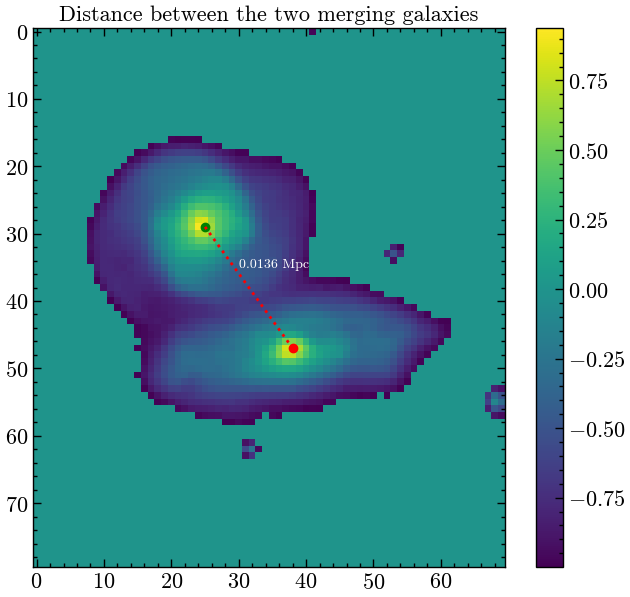

In [81]:
# Figure environment
fig, ax = plt.subplots(figsize=(8, 7))

z = ax.imshow(galaxy_data2D_clean, cmap = "viridis")
ax.scatter(coord_max[0][1], coord_max[0][0], color = "green", marker = "o")
ax.scatter(coord_max[1][1], coord_max[1][0], color = "red", marker = "o")

ax.plot([coord_max[0][1], coord_max[1][1]],[coord_max[0][0], coord_max[1][0]],
        linestyle = ":",color = "red")

plt.text(30, 35, "0.0136 Mpc", fontsize = 10, color = "white")

plt.colorbar(z)

ax.set_title("Distance between the two merging galaxies")
plt.savefig("./galaxies_distance")
plt.show()
plt.close()

### 6. (6 points) Turbulence in 2D

We want to study the properties of the velocity field of turbulent flows in 2D. Let us consider a high-resolution version of the turbulence-in-a-box simulation we analysed in class:

https://github.com/wbandabarragan/computational-physics-1/tree/main/exams/data_sets/TURB_DRIVE_SUP_hr.zip

This simulation introduces a stochastic force field to generate turbulent motions in an isothermal ($\gamma=1$) gas initially at rest. Turbulence is continuously generated throughout the whole simulation time.

The simulation folder contains 101 VTK files, jointly with:

- a **units.out** file that contains the CGS normalisation values.
- a **vtk.out** file whose second column contains the times in code units.

Each VTK file stores the following fields:

- density (rho)
- velocity_x (vx1)
- velocity_y (vx2)
- magnetic_field_x (Bx1)
- magnetic_field_y (Bx2)

We will only use the velocity field for this exercise.


(a) Write a python function that reads and returns the components of the velocity field normalised in CGS units, for any VTK file.

In [82]:
def ReadUnits(filename):
    ''' 
    Read the units.out file and return the
    normalisation units for the simulation.

    Arguments:
            - filename (str) : the path to the units.out file

    Returns:
            - L_0 (float)   : the length normalisation in cm
            - v_0 (float)   : the velocity normalisation in cm/s
            - rho_0 (float) : the density normalisation in g/cm^3
            - p_0 (float)   : the thermal pressure normalisation in dyne/cm^2
            - B_0 (float)   : the magnetic field normalisation in G
            - t_0 (float)   : the time normalisation in s
    '''

    df_units = pd.read_csv(filename)

    # read the units and put them into a numpy array
    rho_0 = np.array(df_units.loc[df_units['variable'] == 'rho_0']['normalisation'])
    v_0   = np.array(df_units.loc[df_units['variable'] == 'v_0']['normalisation'])
    L_0   = np.array(df_units.loc[df_units['variable'] == 'L_0']['normalisation'])
    c_iso = np.array(df_units.loc[df_units['variable'] == 'c_iso']['normalisation'])

    return rho_0, v_0, L_0, c_iso

In [86]:
# Set directory and file name 
directory = "./TURB_DRIVE_SUP_hr/"
file_name_1 = "units.out"

In [88]:
# Call the function 
rho_0, v_0, L_0, c_iso = ReadUnits(directory + file_name_1)

In [89]:
# Let's compute t_0 
t_0 = L_0/v_0
print(t_0)

[3.086e+12]


In [94]:
# Now. let's get the times from the vtk.out file
file_name_2 = "vtk.out"
time_data = pd.read_csv(directory + file_name_2, sep = r'\s+', header=None)
time_code = time_data.iloc[:,1]

# Get time in CGS units 
time_cgs = time_code*t_0

In [96]:
# Let's open a file to see how the data is organised
directory = "./TURB_DRIVE_SUP_hr/"

# Read the file
mesh = pv.read(directory+"/data.0010.vtk")

#print(mesh)
print(mesh.array_names)

['rho', 'vx1', 'vx2', 'Bx1', 'Bx2']


In [97]:
# Now, let's define the function 
def io_simulation(filename):
    """
    Read the vtk file, extract the data and 
    return reshaped 2D arrays of the data 
    in cgs units.

    Arguments:
            - filename (str) : the path to the vtk file

    Returns:
            - vx1_cgs_2D (np.array) : the x-velocity data in cm/s
            - vx2_cgs_2D (np.array) : the y-velocity data in cm/s
    """
    
    # Opening the mesh
    mesh = pv.read(filename)
    
    # Getting the data arrays
    vx1 = pv.get_array(mesh, "vx1", preference = 'cell') #vx in code units
    vx2 = pv.get_array(mesh, "vx2", preference = 'cell') #vy in code units    
    
    # Convert the arrays to 2D and normalise them
    vx1_cgs2D = (vx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)) * v_0
    vx2_cgs2D = (vx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)) * v_0

    return vx1_cgs2D, vx2_cgs2D

(b) Call the above function for VTK file # 50, calculate the modulus of the velocity field, and make two separate maps: one of the modulus of the velocity field and one of the vector field itself.

In [98]:
# Let's call the function 
vx1_cgs2D, vx2_cgs2D = io_simulation(directory + "data.0050.vtk")

In [99]:
# Compute the modulus of the velocity field 
mag_v2D = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2) 

print(mag_v2D.shape)

(200, 200)


In [100]:
# Before we create a the maps, we need to create a meshgrid 
# Create coordinate vectors
x = np.linspace(mesh.bounds[0], mesh.bounds[1], \
               mesh.dimensions[0] - 1) * L_0
y = np.linspace(mesh.bounds[2], mesh.bounds[3], \
               mesh.dimensions[0] - 1) * L_0

# Generate a grid
x_2D, y_2D = np.meshgrid(x, y)

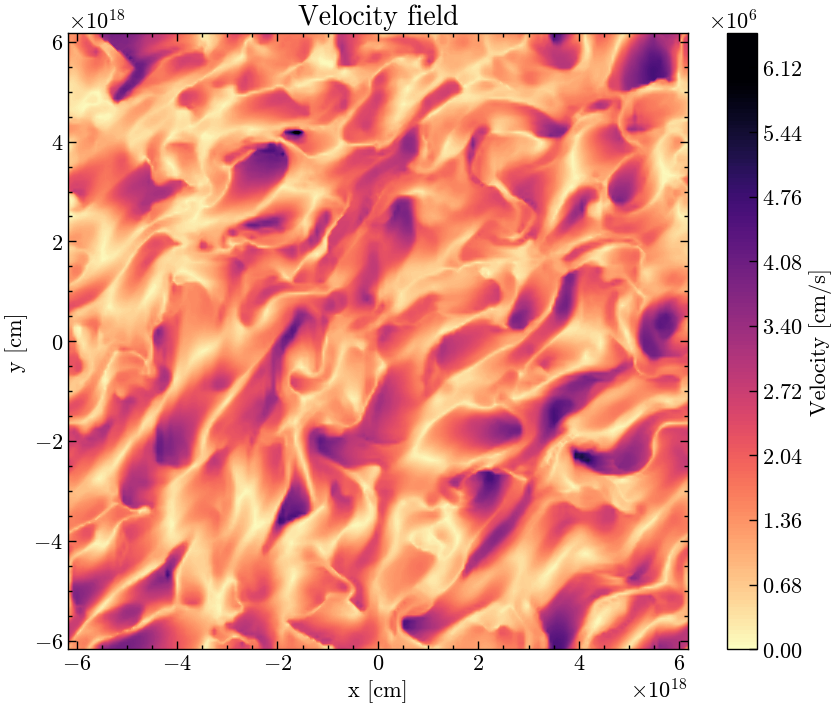

In [114]:
# Map of the modulus of the veloxity 

fig, ax = plt.subplots(figsize = (10, 8))

z3 = ax.contourf(x_2D, y_2D, mag_v2D, 200,  cmap = "magma_r", vmin = 0, vmax = 6e6)
ax.set(xlabel = "x [cm]", ylabel = "y [cm]")
fig.colorbar(z3, ax = ax, label = "Velocity [cm/s]")

ax.set_title("Velocity field", fontsize = 20)

plt.show()
plt.close()

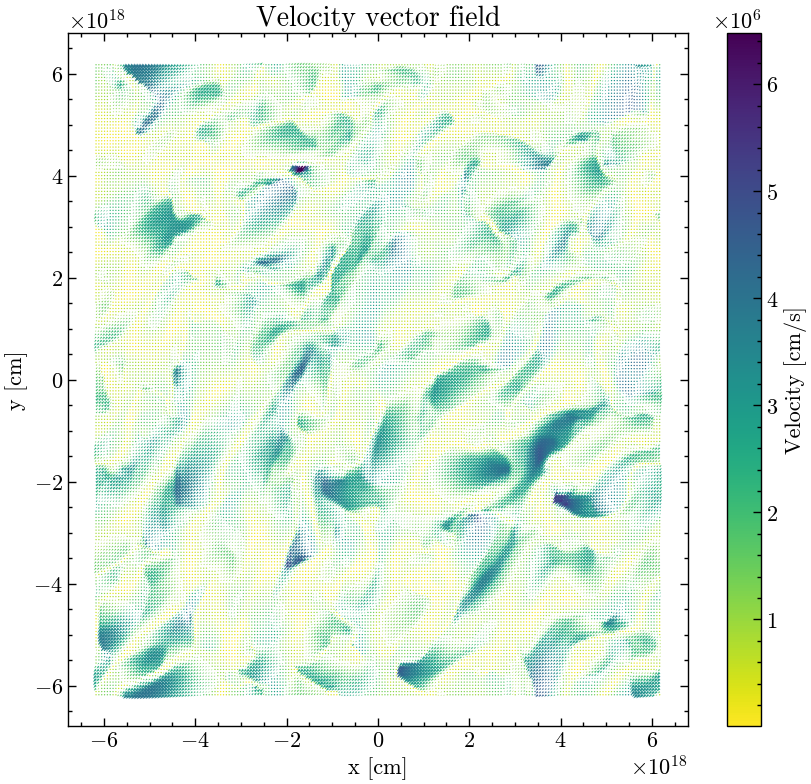

In [115]:
# Figure  
fig, ax = plt.subplots(figsize = (10,9))
z = ax.quiver(x_2D, y_2D, vx1_cgs2D, vx1_cgs2D, mag_v2D, cmap = "viridis_r")
fig.colorbar(z, ax = ax, label = "Velocity [cm/s]")
ax.set(xlabel = "x [cm]", ylabel = "y [cm]")

ax.set_title("Velocity vector field", fontsize = 20)
plt.show()
plt.close()

(c) Make a 1D histogram of the modulus of the velocity field for VTK file # 50. What kind of distribution does it have? Does the disribution follow any of the cases studied in problem 3?

In [116]:
# Now, let's create a histogram 
# Flatten the array 
mag_v1D = mag_v2D.reshape(mag_v2D.size, 1)

print(mag_v1D.size)

40000


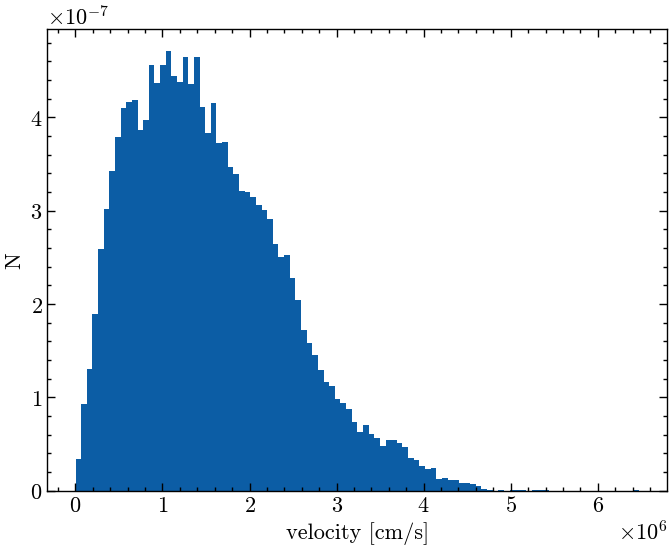

In [117]:
# Histogram (flatten array)
fig, ax = plt.subplots(figsize = (8, 6))
n, bins, patches = ax.hist(mag_v1D, 100, histtype = "stepfilled", lw = 1, density = True)
ax.set(xlabel = "velocity [cm/s]", ylabel = "N")

plt.show()
plt.close()

It has looks like a log-normal distro, which is the third case we studied in problem 3
 

$$\rho_x = \frac{1}{x \sigma \sqrt{2\pi}}exp\left(-\frac{(ln(x)-\mu^2)}{2\sigma^2}\right)$$

We studied a similar case, and the professor also mentioned that it is well known that this distro models this type of problems, although we do not have a good explanation of why. So, we can perform a fitting!!

In [118]:
print(n.shape)
print(bins.shape)

(100,)
(101,)


In [119]:
# They do not have the same shape, let's fix that
x0 = 0.5 * (bins[1 :] + bins[: -1])

print(x0.shape)

(100,)


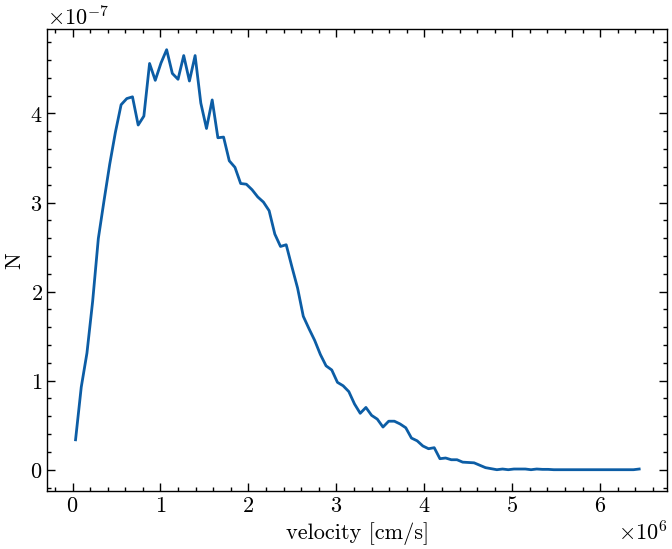

In [120]:
# Now, let's make plot 
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(x0, n, lw = 2.0)
ax.set(xlabel = "velocity [cm/s]", ylabel = "N")
plt.show()
plt.close()

In [121]:
# Define the model for the fit
def log_normal(x, mu, s):
    """
    Function to model a log-normal distribution.

    Arguments:
            - x (np.array) : the x values
            - mu (float) : the mean
            - s (float) : the standard deviation

    Returns:
            - y_model (np.array) : log-normal distribution
    """
    
    y_model = ((np.exp(-(np.log(x) - mu)**2 / (2*s**2)))/(x * s * np.sqrt(2*np.pi)))
    
    return y_model


In [122]:
# Renormalise the axes
n1 = n/1.e-6
x1 = x0/1.e6

In [123]:
# Fitting 
coef, cova = opt.curve_fit(log_normal, x1, n1)
print(coef)

[0.39026169 0.71748986]


In [124]:
# Evaluate the model
n_fit = log_normal(x1, *coef)

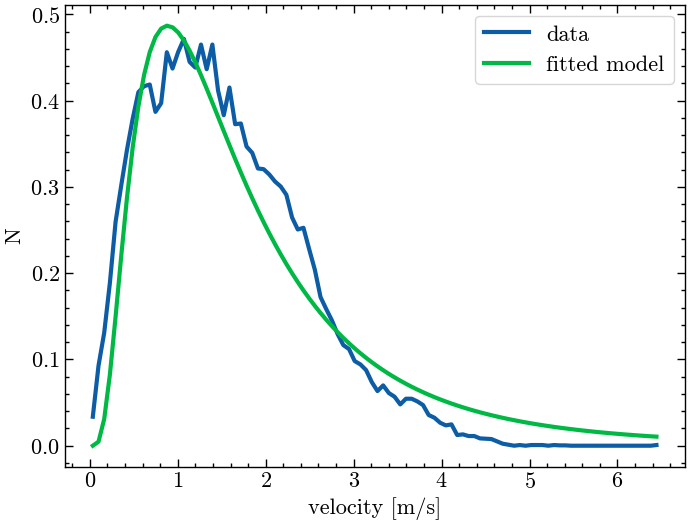

In [127]:
# New histogram plot:
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(x1, n1, lw = 3.0, label = "data")
ax.plot(x1, n_fit, lw = 3.0, label = "fitted model")
ax.set(xlabel = "velocity [m/s]", ylabel = "N")
ax.legend(loc = "best", frameon = True)
plt.show()
plt.close()

(d) Create a set of Python functions that loops over all the simulation VTK files, and computes the following quantities for each time:

- the average velocity, $[v]$,

- the rms velocity, $[v^2]$,

- the (volume-weighted) average velocity dispersion, $\sigma_v = \sqrt{[ v^2 ] - [v ]^2}$.

- the rms Mach number, for which you need $c_{iso}$ given in units.out,

and returns:

- a CSV file with 5 columns, time on the first column, and the above quantities in the next ones.

- figures of each of the above quantities versus time.

In [128]:
# Average velocity 
def AverageVelocity(vx1, vx2):
    """
    Function to compute the average velocity |v|.

    Arguments: 
            - vx1 (np.array) : x-velocity component data
            - vx2 (np.array) : y-velocity component data

    Returns:
            - avg_vel (np.array) : the average velocity
    """
    # calculate the magnitude of the velocity
    v_mag = np.sqrt(vx1**2 + vx2**2)
    
    # compute the average velocity
    avg_vel = np.mean(v_mag)
    
    return avg_vel



# rms velocity 
def RMSVelocity(vx1, vx2): 
    """
    Function to compute the Root Mean Square (RMS) velocity.
    
    Arguments:
            - vx1 (np.array) : x-velocity component data
            - vx2 (np.array) : y-velocity component data
        
    Returns:
            - rms_v (np.array) : the rms velocity
    """
    # compute the rms velocity using the average_velocity function
    rms_v = AverageVelocity(vx1**2, vx2**2) 
    rms_v = np.sqrt(rms_v)
    
    return rms_v


# Volume weighted average velocity dispersion 
def VolumeWeightedAvgVelocity(vx1, vx2):
    """
    Function to compute the volume wigthed average velocity dispersion.

    Arguments:
            - vx1 (np.array) : x-velocity component data
            - vx2 (np.array) : y-velocity component data

    Returns:
            - vel_disp (np.array) : the velocity dispersion
    """
    # call the average_velocity function
    avg_vel = AverageVelocity(vx1, vx2)
    
    # call the rms_velocity function
    rms_v = AverageVelocity(vx1**2, vx2**2) # Using the relation given in class 205
    
    # compute the velocity dispersion
    vel_disp = np.sqrt(rms_v - avg_vel**2)
    
    return vel_disp


# rms match number 
def RMSMatchNumber(vx1, vx2):
    """
    Function to compute the Root Mean Square (RMS) Match number.

    Arguments:
            - vx1 (np.array) : x-velocity component data
            - vx2 (np.array) : y-velocity component data

    Returns:
            - rms_number (np.array) : the rms Match number
    """
    # call the rms_velocity function
    rms_v = RMSVelocity(vx1, vx2)
    
    # compute the rms Match number 
    rms_number = rms_v/c_iso
    
    return rms_number 

In [129]:
# Define empty lists 
av_v1 = []
rms_v1 = []
vw_av_v1 = []
rms_number1 = []

In [130]:
# Loop over all the files

for i in range(0, len(time_cgs)):
    
    # Define filename 
    filename1 = directory + "data.0{:03d}.vtk".format(i) 
    
    # Get the velocity vectors 
    vx1_2D, vx2_2D = io_simulation(filename1)
    
    # Average velocity 
    avg_vel = AverageVelocity(vx1_2D, vx2_2D)
    av_v1.append(avg_vel)
    
    # rms velocity 
    rms_v = RMSVelocity(vx1_2D, vx2_2D)
    rms_v1.append(rms_v)
    
    # Volume weighted average velocity dispersion 
    c = VolumeWeightedAvgVelocity(vx1_2D, vx2_2D)
    vw_av_v1.append(c)
    
    # rms match number 
    n = RMSMatchNumber(vx1_2D, vx2_2D)
    rms_number1.append(n) 

In [131]:
# RMS number list keeps gving me a list of arrays, so I use this line to concatenate them 
rms_number1 = np.concatenate(rms_number1)

In [132]:
# Now, let's put this quantities into a pandas dataframe, and then, into a csv file 
new_df = pd.DataFrame({'Time [s]': time_cgs, 'Average velocity [cm/s]': av_v1,
                      'RMS velocity [cm/s]': rms_v1, 
                      '(volume-weighted) average velocity dispersion': vw_av_v1, 'RMS Mach number': rms_number1})

# Let's put it into a .csv file 
new_df.to_csv('./Quantities.csv', ",", float_format = '{:.4e}'.format)

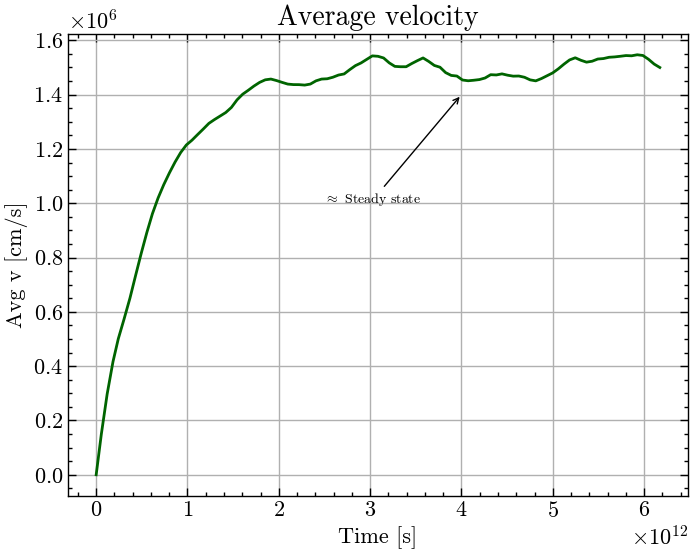

In [138]:
# Now let's generate plots for each of these quantities 
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(time_cgs, np.array(av_v1), color = "darkgreen")


ax.set_xlabel('Time [s]')
ax.set_ylabel('Avg v [cm/s]')
ax.set_title('Average velocity', fontsize = 20)

ax.annotate(r'$\approx$ Steady state', xy=(4e12, 1.4e6), xytext=(2.5e12, 1e6),
             arrowprops=dict(arrowstyle='->'))
plt.grid(True)
plt.show()
plt.close()


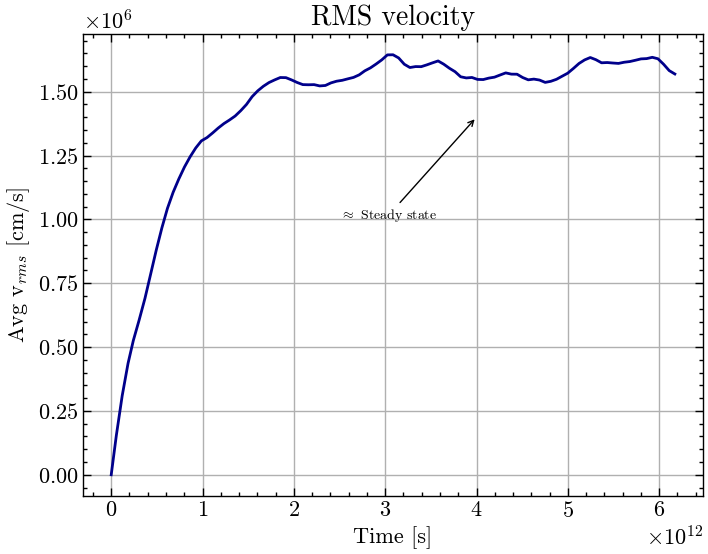

In [144]:
# RMS velocity 
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(time_cgs, np.array(rms_v1), color = "darkblue")
ax.annotate(r'$\approx$ Steady state', xy=(4e12, 1.4e6), xytext=(2.5e12, 1e6),
             arrowprops=dict(arrowstyle='->'))
# labels
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'Avg v$_{rms}$ [cm/s]')
ax.set_title('RMS velocity', fontsize = 20)

plt.grid(True)
plt.show()
plt.close()

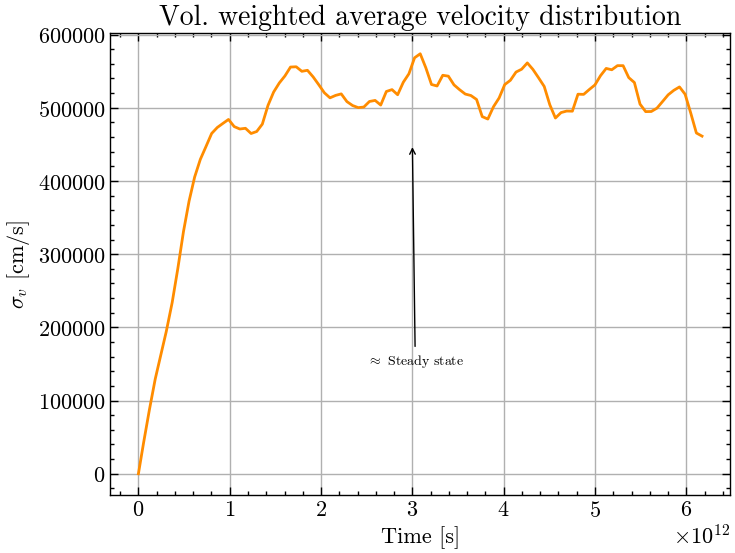

In [146]:
# Volume weighted average velocity dispersion 
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(time_cgs, np.array(vw_av_v1), color = "darkorange")
ax.annotate(r'$\approx$ Steady state', xy=(3e12, 4.5e5), xytext=(2.5e12, 1.5e5),
             arrowprops=dict(arrowstyle='->'))

# labels
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$\sigma_{v}$ [cm/s]')
ax.set_title('Vol. weighted average velocity distribution', fontsize = 20)

plt.grid(True)
plt.show()
plt.close()

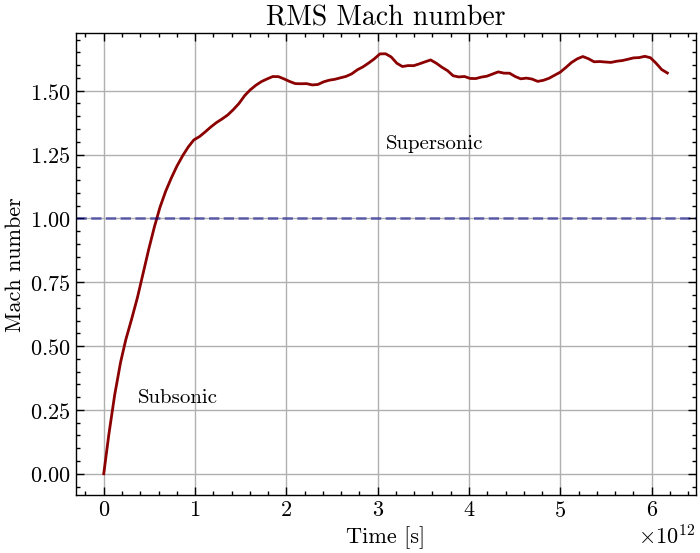

In [157]:
# rms match number 
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(time_cgs, np.array(rms_number1), color = "darkred")
ax.axhline(y=1, color='darkblue', alpha = 0.5 , linestyle='--')

ax.text(0.5, 0.75, "Supersonic", fontsize=15, color='black',transform=ax.transAxes)
ax.text(0.1, 0.2, "Subsonic", fontsize=15, color='black',transform=ax.transAxes)

ax.set_xlabel('Time [s]')
ax.set_ylabel('Mach number')
ax.set_title('RMS Mach number', fontsize = 20)

plt.grid(True)
plt.show()
plt.close()


(e) Create a Python function that return movies showing the time evolution of:

- a maps of the modulus of the velocity field, jointly with
- the rms Mach numbers computed in (c).

Does the flow reach steady state?

In [151]:
# Define a function 
def animation_plots(filename):
    """
    Function that computes the modulus of the velocity field and the 
    rms mach number and returns the data in a numpy array.

    Arguments:
            - filename (str) : the path to the vtk file

    Returns:
            - mag_velocity (np.array) : the modulus of the velocity field
            - rms_num (np.array) : the rms match number
    """
    
    # call the io_simulation function
    vx1_cgs2D, vx2_cgs2D = io_simulation(filename)
    
    # Compute the modulus of the velocity field 
    mag_velocity = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2)
    
    # rms match number 
    rms_num = RMSMatchNumber(vx1_cgs2D, vx2_cgs2D)
    
    return mag_velocity, rms_num

In [153]:
# Let's create a directory to save our figures 
if os.path.isdir("./figures-midterm"):
    print("Directory already exists.")
else: 
    print("Directory has been created.")
    os.mkdir("./figures-midterm")

anim_directory = "./figures-midterm/"

Directory has been created.


In [163]:
# define empty lists 
time = []
match_number = []

# Loop over all the files and generate the plots
for i in range(0,len(time_cgs)):
    
    # Define filename 
    filename2 = directory + "data.0{:03d}.vtk".format(i) 
    
    # get the time 
    t = time_cgs[i]
    time.append(t)
    
    # call the animation_plots function
    mag_velocity, n = animation_plots(filename2)
    
    # get the match number 
    match_number.append(n)
    
    # Generate maps for the modulus of the velocity field 
    
    # Create your first figure
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the first figure with a color bar
    z1 = ax[0].pcolor(x_2D, y_2D, mag_velocity,cmap = "magma_r", vmin = 0, vmax = 6e6)
    cb1 = fig.colorbar(z1, ax=ax[0])
    cb1.set_label(r'$|\vec{v}|$ [cm/s]')
    
    
    # Generate the plot for the match number 
    # Plot the second figure
    ax[1].plot(time, match_number, color = 'darkred')

    ax[1].axhline(y=1, color='darkblue', alpha = 0.5 , linestyle='--')
    ax[1].text(0.5, 0.75, "Supersonic", fontsize=15, color='black',transform=ax[1].transAxes)
    ax[1].text(0.1, 0.2, "Subsonic", fontsize=15, color='black',transform=ax[1].transAxes)
    
    # Add titles and labels for the subplots
    ax[0].set_title('Modulus of the velocity field')
    ax[0].set(xlabel = 'x [cm]', ylabel = 'y [cm]')
    #ax[0].set_ylabel('Y1')

    ax[1].set_title("RMS Match number")
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel("Match number")
    
    ax[1].set_xlim(0, np.max(time_cgs))
    ax[1].set_ylim(0, 1.7)

    fig.suptitle(f'Time [s]: {time_cgs[i]:.2e}', fontsize = 20)
    # Adjust the spacing between subplots
    plt.tight_layout()

    plt.savefig(anim_directory + "vel_mag_and_match_number{:03d}.png".format(i))
    
    plt.close()

In [164]:
# Animation

images_input = "./figures-midterm/vel_mag_and_match_number***.png"
imgif_output = "./Kinetic_energy_density.gif"

# Collect the images 
imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

img = next(imgs)

img.save(fp = imgif_output, format = "GIF", append_images = imgs,\
         save_all = True, duration = 100, loop = 0)

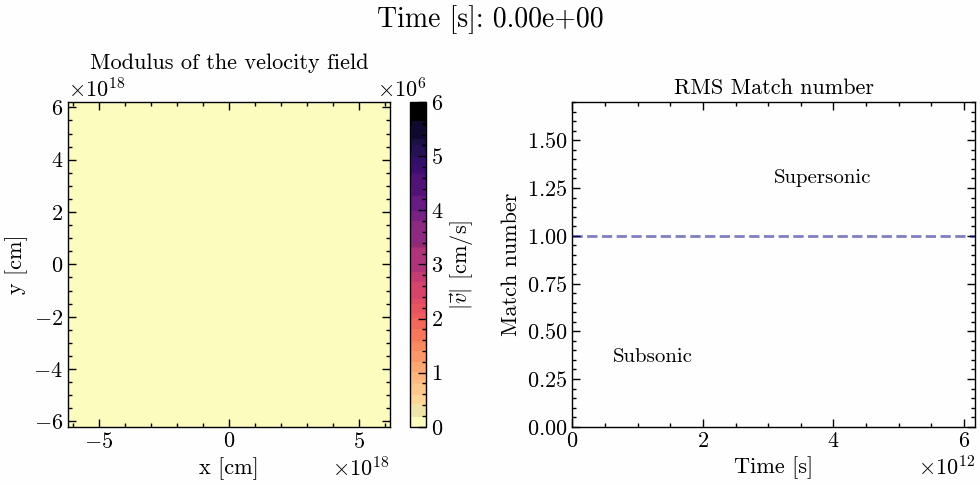

In [165]:
display.Image("./Kinetic_energy_density.gif")

Yeah, the flow reaches the steady state. If we see the plots for the mean velocity, the rms velocity and the RMS match number, we can clearly see that the system actually reaches the steady state. 